In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report

In [2]:
# Paths to the dataset
labeled_images_folder = 'D:/New CX/CXR8/images/Dest'  # Adjust this to the actual folder where your images are stored
labels_csv = 'D:/New CX/CXR8/Data_Entry_2017_v2020.csv'  # Path to the CSV file containing labels


In [3]:
# Load the labels CSV file
df = pd.read_csv(labels_csv)


In [4]:
# Display the first few rows of the dataframe to understand its structure
print(df.head())


        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                       

In [5]:
# Verify if the images exist in the folder
missing_files = []
for img_name in df['Image Index']:
    if not os.path.isfile(os.path.join(labeled_images_folder, img_name.strip())):
        missing_files.append(img_name)

print(f"Number of missing files: {len(missing_files)}")
print("Example missing files:", missing_files[:10])

Number of missing files: 0
Example missing files: []


In [6]:
# Filter the dataframe for the diseases of interest
diseases = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
            'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
            'Hernia', 'Pleural_Thickening', 'No Finding']


In [7]:
# Create a new column for single-label classification
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|')[0] if '|' in x else x)


In [8]:
# Filter for the diseases of interest
df = df[df['Finding Labels'].isin(diseases)]

In [9]:
# Count the number of images for each disease class
disease_counts = df['Finding Labels'].value_counts()

In [10]:
# Display the first few rows after filtering
print(df.head())

        Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00000001_000.png   Cardiomegaly            0           1           57   
1  00000001_001.png   Cardiomegaly            1           1           58   
2  00000001_002.png   Cardiomegaly            2           1           58   
3  00000002_000.png     No Finding            0           2           80   
4  00000003_001.png         Hernia            0           3           74   

  Patient Gender View Position  OriginalImage[Width  Height]  \
0              M            PA                 2682     2749   
1              M            PA                 2894     2729   
2              M            PA                 2500     2048   
3              M            PA                 2500     2048   
4              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                        0.143  0.143  
2                        0.168  0.168 

In [11]:
# Print the counts
print(disease_counts)

Finding Labels
No Finding            60361
Infiltration          11795
Atelectasis           11545
Effusion               8040
Consolidation          3331
Nodule                 3009
Mass                   2926
Cardiomegaly           2404
Pneumothorax           2200
Edema                  1862
Emphysema              1734
Pleural_Thickening     1217
Fibrosis               1215
Pneumonia               325
Hernia                  156
Name: count, dtype: int64


In [12]:
# Randomize and split the dataset
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Finding Labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.67, stratify=temp_df['Finding Labels'], random_state=42)


In [13]:
# Display the distribution
print(f"Training set: {train_df.shape[0]} samples")
print(f"Validation set: {val_df.shape[0]} samples")
print(f"Testing set: {test_df.shape[0]} samples")


Training set: 78484 samples
Validation set: 11099 samples
Testing set: 22537 samples


In [14]:
# Data generator for training, validation, and testing
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=labeled_images_folder,
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(128, 128), ############### 224, 224
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=labeled_images_folder,
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(128, 128), ############### 224, 224
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=labeled_images_folder,
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(128, 128), ############### 224, 224
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)


Found 78484 validated image filenames belonging to 15 classes.
Found 11099 validated image filenames belonging to 15 classes.
Found 22537 validated image filenames belonging to 15 classes.


In [15]:
# Load pre-trained DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [16]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(diseases), activation='softmax')(x)

In [17]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# Compile the model using SGD
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/50
2453/2453 [==============================] - 1367s 557ms/step - loss: 1.3572 - accuracy: 0.5689 - val_loss: 1.4277 - val_accuracy: 0.5617
Epoch 2/50
2453/2453 [==============================] - 1324s 540ms/step - loss: 1.3017 - accuracy: 0.5808 - val_loss: 1.4977 - val_accuracy: 0.5506
Epoch 3/50
2453/2453 [==============================] - 1335s 544ms/step - loss: 1.2403 - accuracy: 0.5940 - val_loss: 1.4575 - val_accuracy: 0.5532
Epoch 4/50
2453/2453 [==============================] - 1351s 551ms/step - loss: 1.1805 - accuracy: 0.6101 - val_loss: 1.5157 - val_accuracy: 0.5473
Epoch 5/50
2453/2453 [==============================] - 1334s 544ms/step - loss: 1.1210 - accuracy: 0.6259 - val_loss: 1.5480 - val_accuracy: 0.5384
Epoch 6/50
2453/2453 [==============================] - 1332s 543ms/step - loss: 1.0541 - accuracy: 0.6468 - val_loss: 1.6462 - val_accuracy: 0.5257
Epoch 7/50
2453/2453 [==============================] - 1349s 550ms/step - loss: 0.9860 - accuracy: 0.6639

In [30]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")


705/705 [==============================] - 334s 474ms/step - loss: 4.3584 - accuracy: 0.5010
Test Accuracy: 0.5009983777999878


In [31]:

# Predict on the test set
test_generator.reset()
predictions = model.predict(test_generator)

705/705 [==============================] - 253s 358ms/step


In [32]:
import numpy as np

In [33]:
# Get true labels and predicted labels
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

In [34]:
# Map indices to class labels
class_labels = list(test_generator.class_indices.keys())
true_labels = [class_labels[i] for i in true_labels]
predicted_labels = [class_labels[i] for i in predicted_labels]

In [35]:
# Print a classification report
print(classification_report(true_labels, predicted_labels, target_names=class_labels))


                    precision    recall  f1-score   support

       Atelectasis       0.32      0.25      0.28      2321
      Cardiomegaly       0.23      0.18      0.20       483
     Consolidation       0.11      0.07      0.08       669
             Edema       0.14      0.23      0.17       375
          Effusion       0.29      0.29      0.29      1616
         Emphysema       0.29      0.14      0.19       348
          Fibrosis       0.10      0.04      0.05       244
            Hernia       0.09      0.03      0.05        32
      Infiltration       0.21      0.21      0.21      2371
              Mass       0.25      0.20      0.22       588
        No Finding       0.66      0.77      0.71     12133
            Nodule       0.13      0.03      0.05       605
Pleural_Thickening       0.03      0.02      0.02       245
         Pneumonia       0.00      0.00      0.00        65
      Pneumothorax       0.20      0.07      0.11       442

          accuracy                    

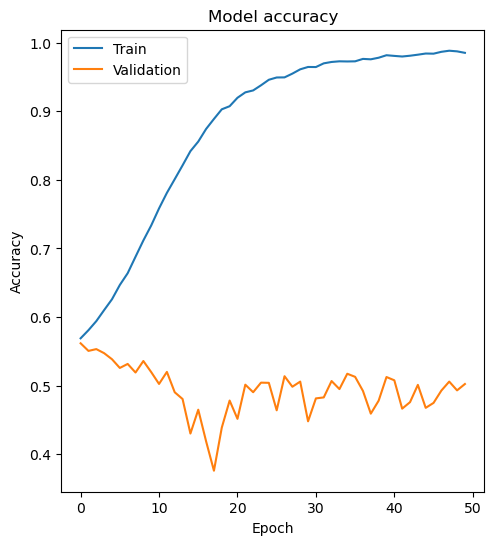

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

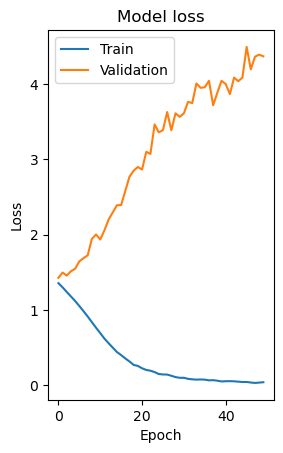

In [37]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()